# Examples of using trap_util.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap

In [2]:
f = 1.5e9 #Hz
me = 9.10938356e-31 #kg (electron)
q = -1.60217662e-19 # coulombs

## Trapping with RF Field

### Loading RF E-field data from .fld files given by the finite-element simulation

In [3]:
# loading E-field (may takes some time depending on the file size)
data = np.loadtxt("etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)
# manipulating E field data and read it into a pandas dataframe
df_RF = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df_RF.x.max(), df_RF.x.min()
y_max, y_min = df_RF.y.max(), df_RF.y.min()
Nx, Ny = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size

# instantiating the trap_RF object from quarter_trap class
trap_RF = quarter_trap(df_RF, x_max, x_min, y_max, y_min, Nx, Ny, dx, dy, f=f, q=q, m=me)
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um") 

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


In [4]:
# testing the implementation of get_row_index
n = trap_RF.get_row_index(2.34568e-4, 7.142857e-5)
trap_RF.df.iloc[n, :]

x         0.000234
y         0.000071
z         0.000000
Ex   -27665.112961
Ey    10432.355635
Ez        0.000000
Name: 5629223, dtype: float64

Text(0,0.5,'y (m)')

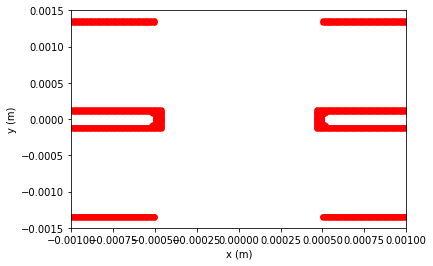

In [5]:
# testing the implementation of hit_electrodes
for x in np.linspace(trap_RF.x_min, trap_RF.x_max, 231):
    for y in np.linspace(trap_RF.y_min, trap_RF.y_max, 233):
        if trap_RF.hit_electrodes(x, y):
            plt.plot(x, y, "r.")
            plt.plot(x, -y, "r.")
            plt.plot(-x, y, "r.")
            plt.plot(-x, -y, "r.")
plt.xlim((-x_max, x_max))
plt.ylim((-y_max, y_max))
plt.xlabel("x (m)")
plt.ylabel("y (m)")

### Plotting Single Particle Trajectory (Trapping)

x_max =  1000.0 um
y_max =  1500.0 um
x_min =  0.0 um
y_min =  0.0 um
Spatial resolution x:  0.25 um
Spatial resolution y:  0.25 um
Time step for simulation:  0.01 ns
Program runtime: 4.2 s


Text(0.5,1,'y vs x')

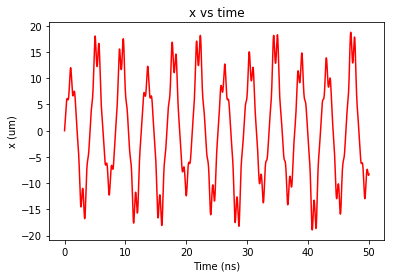

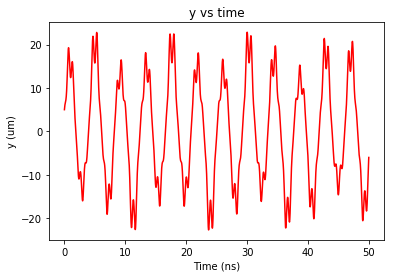

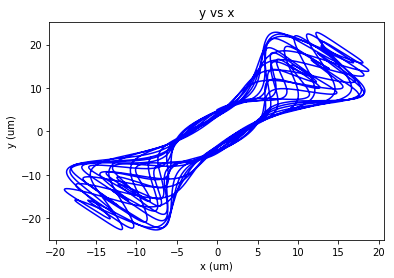

In [6]:
start = time.time()
# simulation configuration
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation
T = 20.0 # kelvin
rho = 5.0e-6 # initial distance from the trap center
phi = np.pi/2 # direction of initial position vector
v = np.sqrt(2*trap_RF.kB*T/trap_RF.m) # typical thermal speed
theta = np.pi/4 # direction of initial velocity
# simulate particle trajectory using trap_RF object
result = trap_RF.traj(rho, phi, v, theta, dt, t_max)
t_s = np.array(result[0])
x_traj = np.array(result[1])
y_traj = np.array(result[2])

print("x_max = ", x_max*1.0e6, "um")
print("y_max = ", y_max*1.0e6, "um")
print("x_min = ", x_min*1.0e6, "um")
print("y_min = ", y_min*1.0e6, "um")
print("Spatial resolution x: ", dx*1.0e6, "um")
print("Spatial resolution y: ", dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
end = time.time()
print("Program runtime:", round(end-start, 1), "s")

# Plotting the results
plt.figure()
plt.plot(t_s*1.0e9, x_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("x (um)")
plt.title("x vs time")

plt.figure()
plt.plot(t_s*1.0e9, y_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("y (um)")
plt.title("y vs time")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6, 'b-')
plt.xlabel("x (um)")
plt.ylabel("y (um)")
plt.title("y vs x")

### An example of exploring the trapping success rate under a certain temperature using Boltzmann_sim

In [7]:
start = time.time()
N_samples = 200
T = 20.0 #kelvin
dt = 1.0e-11 #s
t_max = 5.0e-8 #s
FWHM = 50.0e-6 #m
# calling the Boltzmann_sim method will print the result of the simulation;
# the result is also returned as a 1D array of 0s and 1s
result = trap_RF.Boltzmann_sim(N_samples, T, dt, t_max, FWHM)
print(result[0:5])
end = time.time()
print("Runtime of the program: ", round(end-start), "s")

1  samples already simulated
21  samples already simulated
41  samples already simulated
61  samples already simulated
81  samples already simulated
101  samples already simulated
121  samples already simulated
141  samples already simulated
161  samples already simulated
181  samples already simulated
T:  20.0 Kelvin
N_samples:  200
Time step:  0.01 ns
Max Sim Time:  0.049999999999999996 us
FWHM:  50.0 um
Trapping Rate:  0.99 +/- 0.007035623639735144
------
[1, 1, 1, 1, 1]
Runtime of the program:  836 s


## Extraction of electron with a DC field

In [8]:
# loading DC extraction E-field 
data = np.loadtxt("etrap_extraction_40_-40_-200V_smoothExEy_1micron_half.fld", skiprows = 2)
# manipulating E field data
df_DC = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df_DC.x.max(), df_DC.x.min()
y_max, y_min = df_DC.y.max(), df_DC.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx, Ny = df_DC.x.nunique() - 1, df_DC.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size

# instantiating trap_DC object from half_trap class
# note that for DC, f=0
trap_DC = half_trap(df_DC, x_max, x_min, y_max, y_min, Nx, Ny, dx, dy, f=0.0, q=q, m=me)
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")

x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um


In [9]:
# testing the implementation of get_row_index
n = trap_DC.get_row_index(2.34568e-4, 7.142857e-5)
trap_DC.df.iloc[n, :]

x         0.000234
y         0.000071
z         0.000000
Ex     1289.617382
Ey   -12533.079700
Ez        0.000000
Name: 938305, dtype: float64

Text(0,0.5,'y (m)')

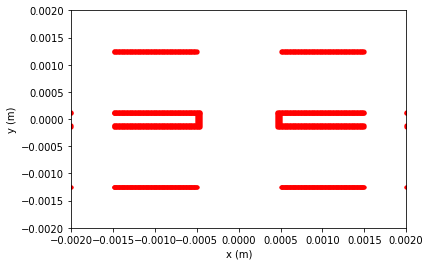

In [10]:
# testing the implementation of hit_electrodes
for x in np.linspace(trap_DC.x_min, trap_DC.x_max, 231):
    for y in np.linspace(trap_DC.y_min, trap_DC.y_max, 233):
        if trap_DC.hit_electrodes(x, y):
            plt.plot(x, y, "r.")
            plt.plot(-x, y, "r.")
plt.xlim((-x_max, x_max))
plt.ylim((-y_max, y_max))
plt.xlabel("x (m)")
plt.ylabel("y (m)")

### Plotting Single Particle Trajectory (Successful Extraction)

Out of bound
x_max =  2000.0 um
y_max =  2000.0 um
x_min =  0.0 um
y_min =  -2000.0 um
Spatial resolution x:  1.0 um
Spatial resolution y:  1.0 um
Time step for simulation:  0.01 ns
Program runtime: 0.1 s


Text(0.5,1,'y vs x trajectory')

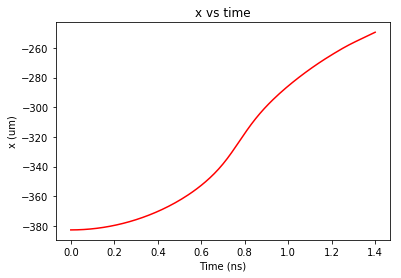

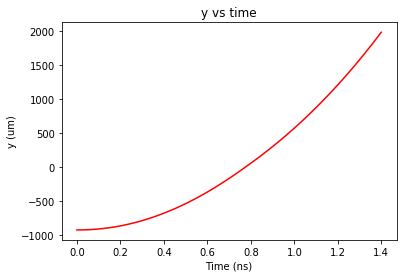

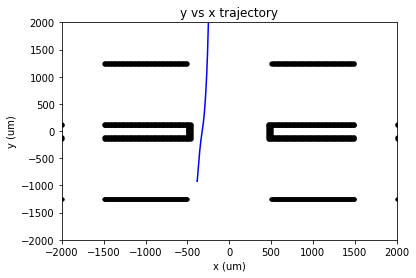

In [11]:
start = time.time()

# simulation configuration
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation
T = 20.0 # kelvin
rho = 1000.0e-6 # initial distance from the trap center
phi = -5*np.pi/8 # direction of initial position vector
v = np.sqrt(2*trap_DC.kB*T/trap_DC.m) # typical thermal speed
theta = -np.pi/2 # direction of initial velocity

# simulate particle trajectory using trap_RF object
result = trap_DC.traj(rho, phi, v, theta, dt, t_max)
t_s = np.array(result[0])
x_traj = np.array(result[1])
y_traj = np.array(result[2])
print("x_max = ", trap_DC.x_max*1.0e6, "um")
print("y_max = ", trap_DC.y_max*1.0e6, "um")
print("x_min = ", trap_DC.x_min*1.0e6, "um")
print("y_min = ", trap_DC.y_min*1.0e6, "um")
print("Spatial resolution x: ", trap_DC.dx*1.0e6, "um")
print("Spatial resolution y: ", trap_DC.dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
end = time.time()
print("Program runtime:", round(end-start, 1), "s")

# Plotting the results
plt.figure()
plt.plot(t_s*1.0e9, x_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("x (um)")
plt.title("x vs time")

plt.figure()
plt.plot(t_s*1.0e9, y_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("y (um)")
plt.title("y vs time")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6, 'b-')
# plotting the electrodes as reference
for x in np.linspace(trap_DC.x_min, trap_DC.x_max, 231):
    for y in np.linspace(trap_DC.y_min, trap_DC.y_max, 233):
        if trap_DC.hit_electrodes(x, y):
            plt.plot(x*1.0e6, y*1.0e6, color='black', marker='.')
            plt.plot(-x*1.0e6, y*1.0e6, color='black', marker='.')
plt.xlim((-x_max*1.0e6, x_max*1.0e6))
plt.ylim((-y_max*1.0e6, y_max*1.0e6))
plt.xlabel("x (um)")
plt.ylabel("y (um)")
plt.title("y vs x trajectory")

In [12]:
# testing trap_DC.extracted
trap_DC.extracted(rho, phi, v, theta, dt, t_max)

True

### Plotting Single Particle Trajectory (Unsuccessful Extraction)

Out of bound
x_max =  2000.0 um
y_max =  2000.0 um
x_min =  0.0 um
y_min =  -2000.0 um
Spatial resolution x:  1.0 um
Spatial resolution y:  1.0 um
Time step for simulation:  0.01 ns
Program runtime: 0.1 s


Text(0.5,1,'y vs x trajectory')

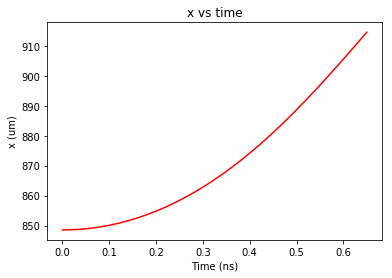

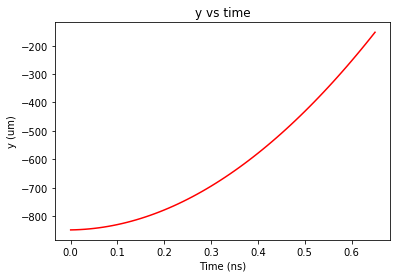

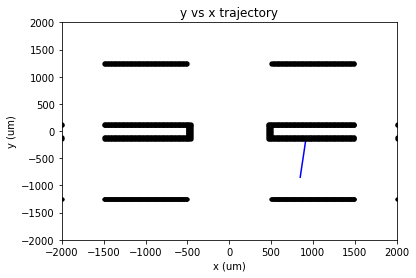

In [13]:
start = time.time()
# simulation configuration
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation
T = 20.0 # kelvin
rho = 1200.0e-6 # initial distance from the trap center
phi = -np.pi/4 # direction of initial position vector
v = np.sqrt(2*trap_DC.kB*T/trap_DC.m) # typical thermal speed
theta = np.pi/2 # direction of initial velocity

# simulate particle trajectory using trap_RF object
result = trap_DC.traj(rho, phi, v, theta, dt, t_max)
t_s = np.array(result[0])
x_traj = np.array(result[1])
y_traj = np.array(result[2])
print("x_max = ", trap_DC.x_max*1.0e6, "um")
print("y_max = ", trap_DC.y_max*1.0e6, "um")
print("x_min = ", trap_DC.x_min*1.0e6, "um")
print("y_min = ", trap_DC.y_min*1.0e6, "um")
print("Spatial resolution x: ", trap_DC.dx*1.0e6, "um")
print("Spatial resolution y: ", trap_DC.dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
end = time.time()
print("Program runtime:", round(end-start, 1), "s")

# Plotting the results
plt.figure()
plt.plot(t_s*1.0e9, x_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("x (um)")
plt.title("x vs time")

plt.figure()
plt.plot(t_s*1.0e9, y_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("y (um)")
plt.title("y vs time")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6, 'b-')
# plotting the electrodes as reference
for x in np.linspace(trap_DC.x_min, trap_DC.x_max, 231):
    for y in np.linspace(trap_DC.y_min, trap_DC.y_max, 233):
        if trap_DC.hit_electrodes(x, y):
            plt.plot(x*1.0e6, y*1.0e6, color='black', marker='.')
            plt.plot(-x*1.0e6, y*1.0e6, color='black', marker='.')
plt.xlim((-x_max*1.0e6, x_max*1.0e6))
plt.ylim((-y_max*1.0e6, y_max*1.0e6))
plt.xlabel("x (um)")
plt.ylabel("y (um)")
plt.title("y vs x trajectory")

In [14]:
# testing trap_DC.extracted
trap_DC.extracted(rho, phi, v, theta, dt, t_max)

False